In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from time import strptime
import os 
import patsy 
from shapely.wkt import loads
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests 

In [2]:
#import pickle without zeros 
bg_pkl = open('cinems_bg_pkl_030320', 'rb')

df = pickle.load(bg_pkl)

In [3]:
df.year_month.unique()

array([2017.01, 2017.03, 2017.04, 2017.05, 2017.1 , 2018.07, 2018.1 ,
       2019.11, 2017.06, 2017.09, 2018.01, 2018.03, 2018.04, 2018.05,
       2018.09, 2019.02, 2019.04, 2019.09, 2017.08, 2017.11, 2018.06,
       2018.08, 2019.01, 2019.1 , 2020.01, 2017.02, 2017.07, 2017.12,
       2018.02, 2018.11, 2018.12, 2019.03, 2019.05, 2019.06, 2019.07,
       2019.08, 2019.12, 2020.02])

### Pull Geometry and Census Data 

In [4]:
year='2019'
dsource='pdb/blockgroup'
cols='State_name,County_name,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,pct_NH_White_alone_CEN_2010,pct_NH_Blk_alone_ACS_13_17,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17,Tract'
state='39'
county='061'
place='15000'
api_key='b76534619ffbdeef7355569c1b9cafd6a55fce2b'

In [5]:
base_url = f'https://api.census.gov/data/{year}/{dsource}'

In [6]:
data_url = f'{base_url}?get={cols}&for=block%20group:*&in=state:{state}+place={place}&in=county:{county}&in=tract:*&key={api_key}'



In [7]:
response=requests.get(data_url)

In [8]:
data=response.json()
pdb_bg=pd.DataFrame(data[1:], columns=data[0])

In [9]:
pdb_bg.head()

,State_name,County_name,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,...,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17,Tract,state,county,tract,block group
0,Ohio,Hamilton County,390610002001,1055,49.67,12.7,22.94,22.56,13.27,0.38,...,0,"$18,883",53.55,None,2.9,000200,39,061,000200,1
1,Ohio,Hamilton County,390610007001,293,60.07,29.01,49.15,7.51,14.33,4.44,...,4.78,"$63,977",31.96,None,51.92,000700,39,061,000700,1
2,Ohio,Hamilton County,390610007002,730,51.51,8.08,53.42,24.79,11.78,0.96,...,7.67,"$64,554",12.38,None,67.43,000700,39,061,000700,2
3,Ohio,Hamilton County,390610007003,510,58.82,9.8,40.39,24.12,20,9.22,...,4.12,"$86,974",10,"$284,400",70.07,000700,39,061,000700,3
4,Ohio,Hamilton County,390610009001,633,67.77,7.74,35.7,32.86,8.53,5.85,...,0,"$66,786",38.69,"$415,000",55.53,000900,39,061,000900,1


In [10]:
#tracts in Cincinnati
t = ['45.00', '46.02', '46.03', '46.05', '46.04', '47.02', '266.00', '47.01',
      '48.00', '49.00', '51.00', '53.02',
      '55.00', '56.00', '108.00', '54.00', '53.01',
      '50.00', '52.00', '58.00', '57.01', '57.02', 
      '59.00', '40.00', '38.00', '39.00',
      '41.00', '42.00', '20.00', '19.00', '268.00', '11.00', '18.00', '22.00', 
      '267.00', '33.00', '32.00', '69.00', '270.00', 
      '37.00', '36.00', '66.00', '68.00', '65.00', '64.00', 
      '63.00', '271.00', '61.00', '60.00', '110.00', '80.00', 
      '70.00', '30.00', '23.00', '17.00', '10.00', '07.00', '265.00',
      '02.00', '264.00', '09.00', '16.00', '26.00', '27.00', '29.00', 
      '72.00', '269.00', '71.00', '74.00', '75.00', '73.00', 
      '81.00', '82.02', '82.01', '111.00', '83.00', 
      '84.00', '79.00', '78.00', '85.01', '85.02', 
      '77.00', '28.00', '263.00', '96.00', '95.00', '93.00', 
      '94.00', '92.00', '272.00', '86.01', '88.00', 
      '100.02', '101.00', '102.01', '102.02', '109.00', 
      '100.03', '100.04', '100.05', '107.00', '99.01', 
      '99.02', '97.00', '103.00', '104.00', '105.00', '106.00','98.00','25.00']

In [11]:
tract = pd.DataFrame(t)

In [12]:
tract = tract.astype(float)

In [13]:
tract = tract*100

In [14]:
tract = tract.astype(int)

In [15]:
tract.rename(columns={0:'tract'},inplace=True)

In [16]:
pdb_bg.tract.sort_values()[0:5]

0    000200
1    000700
2    000700
3    000700
4    000900
Name: tract, dtype: object

In [17]:
tract.sort_values(by='tract')[0:5]

,tract
58,200
56,700
60,900
55,1000
31,1100


In [18]:
pdb_bg.tract = pdb_bg.tract.astype(int)

In [19]:
pdb_bg = pdb_bg.merge(tract, left_on='tract', right_on='tract')

In [20]:
import os
os.getcwd()
os.chdir('/Users/drewgobbi/Documents/GitHub/OpioidWasteWaterPilot/tl_2019_39_bg')
oh_bg = gpd.read_file('tl_2019_39_bg.shp')

In [21]:
cin = pdb_bg.merge(oh_bg, left_on='GIDBG', right_on='GEOID')

In [22]:
cin = gpd.GeoDataFrame(cin, geometry=cin.geometry)

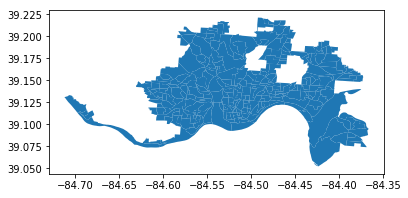

In [23]:
cin.plot()

In [24]:
len(cin.GIDBG.unique())

284

In [25]:
cin.dtypes

State_name                         object
County_name                        object
GIDBG                              object
Tot_Population_ACS_13_17           object
pct_Males_ACS_13_17                object
pct_Pop_18_24_ACS_13_17            object
pct_Pop_25_44_ACS_13_17            object
pct_Pop_45_64_ACS_13_17            object
pct_Pop_65plus_ACS_13_17           object
pct_Hispanic_ACS_13_17             object
pct_NH_White_alone_CEN_2010        object
pct_NH_Blk_alone_ACS_13_17         object
pct_NH_Asian_alone_ACS_13_17       object
Med_HHD_Inc_BG_ACS_13_17           object
pct_Prs_Blw_Pov_Lev_ACS_13_17      object
Med_House_Value_BG_ACS_13_17       object
pct_College_ACS_13_17              object
Tract                              object
state                              object
county                             object
tract                               int64
block group                        object
STATEFP                            object
COUNTYFP                          

### Get EMS calls

In [26]:
### create shell dataframe for the years
years = [2017, 2018, 2019, 2020]
months = np.arange(.01,.13,.01)

In [27]:
#get list of all possible years
year_month = []
for i in range(len(years)):
    for j in range(len(months)):
        ym = years[i] + months[j]
        year_month.append(ym)

In [28]:
len(year_month)

48

In [29]:
cin.shape

(284, 35)

In [30]:
ciny = pd.DataFrame()
cin['year_month'] = 0
for i in range(len(year_month)):
    cin['year_month'] = year_month[i]
    ciny = pd.concat([ciny, cin], axis = 0)

In [31]:
ciny

,State_name,County_name,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,...,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,year_month
0,Ohio,Hamilton County,390610002001,1055,49.67,12.7,22.94,22.56,13.27,0.38,...,390610002001,Block Group 1,G5030,S,303042,0,+39.1097447,-084.5296140,"POLYGON ((-84.53186 39.11390, -84.53157 39.113...",2017.01
1,Ohio,Hamilton County,390610007001,293,60.07,29.01,49.15,7.51,14.33,4.44,...,390610007001,Block Group 1,G5030,S,100014,0,+39.1063957,-084.5089390,"POLYGON ((-84.51127 39.10764, -84.50968 39.107...",2017.01
2,Ohio,Hamilton County,390610007002,730,51.51,8.08,53.42,24.79,11.78,0.96,...,390610007002,Block Group 2,G5030,S,293250,0,+39.1043034,-084.5157347,"POLYGON ((-84.51926 39.10640, -84.51843 39.106...",2017.01
3,Ohio,Hamilton County,390610007003,510,58.82,9.8,40.39,24.12,20,9.22,...,390610007003,Block Group 3,G5030,S,391005,0,+39.1037963,-084.5089372,"POLYGON ((-84.51425 39.10628, -84.51265 39.106...",2017.01
4,Ohio,Hamilton County,390610009001,633,67.77,7.74,35.7,32.86,8.53,5.85,...,390610009001,Block Group 1,G5030,S,136091,0,+39.1116424,-084.5182760,"POLYGON ((-84.52104 39.11323, -84.52042 39.113...",2017.01
5,Ohio,Hamilton County,390610009002,1111,56.62,13.32,33.84,27.09,5.49,11.52,...,390610009002,Block Group 2,G5030,S,165805,0,+39.1085073,-084.5173258,"POLYGON ((-84.52016 39.10987, -84.51858 39.110...",2017.01
6,Ohio,Hamilton County,390610016001,555,44.5,8.47,30.63,19.46,13.15,3.78,...,390610016001,Block Group 1,G5030,S,128956,0,+39.1150670,-084.5180552,"POLYGON ((-84.52017 39.11635, -84.51971 39.116...",2017.01
7,Ohio,Hamilton County,390610016002,442,56.11,7.47,25.79,41.4,2.49,0,...,390610016002,Block Group 2,G5030,S,213905,0,+39.1177653,-084.5218424,"POLYGON ((-84.52619 39.12145, -84.52615 39.121...",2017.01
8,Ohio,Hamilton County,390610010001,481,48.02,2.7,50.73,17.67,5.82,0.62,...,390610010001,Block Group 1,G5030,S,75673,0,+39.1112059,-084.5142961,"POLYGON ((-84.51595 39.11292, -84.51530 39.112...",2017.01
9,Ohio,Hamilton County,390610010002,1013,53.31,6.42,51.63,19.55,5.92,7.6,...,390610010002,Block Group 2,G5030,S,172440,0,+39.1096245,-084.5121748,"POLYGON ((-84.51506 39.10944, -84.51458 39.109...",2017.01


In [32]:
### check that it copied the df for each year_month
284*len(year_month)

13632

In [33]:
len(ciny.year_month.unique())

48

In [34]:
df.ems_calls.describe()

count    3339.000000
mean        1.773285
std         1.468195
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        19.000000
Name: ems_calls, dtype: float64

In [35]:
ciny.GIDBG = ciny.GIDBG.astype(float)

In [36]:
ciny.head()

,State_name,County_name,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,...,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,year_month
0,Ohio,Hamilton County,3.906100e+11,1055,49.67,12.7,22.94,22.56,13.27,0.38,...,390610002001,Block Group 1,G5030,S,303042,0,+39.1097447,-084.5296140,"POLYGON ((-84.53186 39.11390, -84.53157 39.113...",2017.01
1,Ohio,Hamilton County,3.906100e+11,293,60.07,29.01,49.15,7.51,14.33,4.44,...,390610007001,Block Group 1,G5030,S,100014,0,+39.1063957,-084.5089390,"POLYGON ((-84.51127 39.10764, -84.50968 39.107...",2017.01
2,Ohio,Hamilton County,3.906100e+11,730,51.51,8.08,53.42,24.79,11.78,0.96,...,390610007002,Block Group 2,G5030,S,293250,0,+39.1043034,-084.5157347,"POLYGON ((-84.51926 39.10640, -84.51843 39.106...",2017.01
3,Ohio,Hamilton County,3.906100e+11,510,58.82,9.8,40.39,24.12,20,9.22,...,390610007003,Block Group 3,G5030,S,391005,0,+39.1037963,-084.5089372,"POLYGON ((-84.51425 39.10628, -84.51265 39.106...",2017.01
4,Ohio,Hamilton County,3.906100e+11,633,67.77,7.74,35.7,32.86,8.53,5.85,...,390610009001,Block Group 1,G5030,S,136091,0,+39.1116424,-084.5182760,"POLYGON ((-84.52104 39.11323, -84.52042 39.113...",2017.01


In [37]:
ems = df.filter(['GIDBG', 'ems_calls', 'year_month'])

In [38]:
ems.head()

,GIDBG,ems_calls,year_month
0,3.906101e+11,1,2017.01
1,3.906101e+11,1,2017.03
2,3.906101e+11,1,2017.04
3,3.906101e+11,2,2017.05
4,3.906101e+11,1,2017.10


In [39]:
full = ciny.merge(ems, on=['GIDBG', 'year_month'], how='left')

In [40]:
full.shape

(13632, 37)

In [41]:
full.ems_calls.replace(np.NaN, 0, inplace=True)

In [42]:
full.head()

,State_name,County_name,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,...,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,year_month,ems_calls
0,Ohio,Hamilton County,3.906100e+11,1055,49.67,12.7,22.94,22.56,13.27,0.38,...,Block Group 1,G5030,S,303042,0,+39.1097447,-084.5296140,"POLYGON ((-84.53186 39.11390, -84.53157 39.113...",2017.01,0.0
1,Ohio,Hamilton County,3.906100e+11,293,60.07,29.01,49.15,7.51,14.33,4.44,...,Block Group 1,G5030,S,100014,0,+39.1063957,-084.5089390,"POLYGON ((-84.51127 39.10764, -84.50968 39.107...",2017.01,1.0
2,Ohio,Hamilton County,3.906100e+11,730,51.51,8.08,53.42,24.79,11.78,0.96,...,Block Group 2,G5030,S,293250,0,+39.1043034,-084.5157347,"POLYGON ((-84.51926 39.10640, -84.51843 39.106...",2017.01,6.0
3,Ohio,Hamilton County,3.906100e+11,510,58.82,9.8,40.39,24.12,20,9.22,...,Block Group 3,G5030,S,391005,0,+39.1037963,-084.5089372,"POLYGON ((-84.51425 39.10628, -84.51265 39.106...",2017.01,9.0
4,Ohio,Hamilton County,3.906100e+11,633,67.77,7.74,35.7,32.86,8.53,5.85,...,Block Group 1,G5030,S,136091,0,+39.1116424,-084.5182760,"POLYGON ((-84.52104 39.11323, -84.52042 39.113...",2017.01,0.0


In [43]:
sum(full.ems_calls)

5921.0

In [44]:
#these should match
#df was created by just grabbing block groups with >=1 ems calls in it
#full includes all bg over the timeperiod, including the zeros
df.ems_calls.sum()

5921

In [45]:
#test monthly totals to see where we don't have data
#looks like we don't have anything past february 2020
full.groupby('year_month').sum()

,GIDBG,tract,ALAND,AWATER,ems_calls
year_month,,,,,
2017.01,1.109333e+14,2415930,211953482,4716469,127.0
2017.02,1.109333e+14,2415930,211953482,4716469,199.0
2017.03,1.109333e+14,2415930,211953482,4716469,311.0
2017.04,1.109333e+14,2415930,211953482,4716469,273.0
2017.05,1.109333e+14,2415930,211953482,4716469,257.0
2017.06,1.109333e+14,2415930,211953482,4716469,249.0
2017.07,1.109333e+14,2415930,211953482,4716469,193.0
2017.08,1.109333e+14,2415930,211953482,4716469,228.0
2017.09,1.109333e+14,2415930,211953482,4716469,220.0


In [46]:
full.sort_values(by='year_month', inplace=True)

In [47]:
#there are 12*3 + 2 = 38 months from 2017 to February 2020
#284 block groups per year month in the sample
#so can cut off after the 38*284 value when sorted by year_month
284*38


10792

In [48]:
full.year_month[10790:10793]

10598    2020.02
10603    2020.02
10985    2020.03
Name: year_month, dtype: float64

In [49]:
full = full[:10792]

In [50]:
full.year_month.unique()

array([2017.01, 2017.02, 2017.03, 2017.04, 2017.05, 2017.06, 2017.07,
       2017.08, 2017.09, 2017.1 , 2017.11, 2017.12, 2018.01, 2018.02,
       2018.03, 2018.04, 2018.05, 2018.06, 2018.07, 2018.08, 2018.09,
       2018.1 , 2018.11, 2018.12, 2019.01, 2019.02, 2019.03, 2019.04,
       2019.05, 2019.06, 2019.07, 2019.08, 2019.09, 2019.1 , 2019.11,
       2019.12, 2020.01, 2020.02])

In [51]:
full.head()

,State_name,County_name,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,...,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,year_month,ems_calls
0,Ohio,Hamilton County,3.906100e+11,1055,49.67,12.7,22.94,22.56,13.27,0.38,...,Block Group 1,G5030,S,303042,0,+39.1097447,-084.5296140,"POLYGON ((-84.53186 39.11390, -84.53157 39.113...",2017.01,0.0
180,Ohio,Hamilton County,3.906101e+11,2187,40.74,14.77,17.01,17.47,21.03,0.18,...,Block Group 1,G5030,S,2920263,0,+39.1886155,-084.5544834,"POLYGON ((-84.56745 39.19287, -84.56706 39.193...",2017.01,0.0
181,Ohio,Hamilton County,3.906101e+11,216,34.72,12.96,12.5,66.2,0,16.2,...,Block Group 1,G5030,S,4176656,0,+39.1706703,-084.5692113,"POLYGON ((-84.58253 39.17047, -84.58252 39.170...",2017.01,1.0
182,Ohio,Hamilton County,3.906101e+11,2509,40.77,6.78,29.1,14.67,2.67,3.79,...,Block Group 2,G5030,S,1209614,0,+39.1848016,-084.5632113,"POLYGON ((-84.57038 39.19125, -84.56881 39.191...",2017.01,1.0
183,Ohio,Hamilton County,3.906101e+11,336,52.08,9.52,18.15,29.76,27.68,12.8,...,Block Group 3,G5030,S,757754,0,+39.1746528,-084.5567343,"POLYGON ((-84.56274 39.17782, -84.55517 39.179...",2017.01,0.0


In [52]:
full.dtypes

State_name                         object
County_name                        object
GIDBG                             float64
Tot_Population_ACS_13_17           object
pct_Males_ACS_13_17                object
pct_Pop_18_24_ACS_13_17            object
pct_Pop_25_44_ACS_13_17            object
pct_Pop_45_64_ACS_13_17            object
pct_Pop_65plus_ACS_13_17           object
pct_Hispanic_ACS_13_17             object
pct_NH_White_alone_CEN_2010        object
pct_NH_Blk_alone_ACS_13_17         object
pct_NH_Asian_alone_ACS_13_17       object
Med_HHD_Inc_BG_ACS_13_17           object
pct_Prs_Blw_Pov_Lev_ACS_13_17      object
Med_House_Value_BG_ACS_13_17       object
pct_College_ACS_13_17              object
Tract                              object
state                              object
county                             object
tract                               int64
block group                        object
STATEFP                            object
COUNTYFP                          

In [53]:
full.Med_HHD_Inc_BG_ACS_13_17.head()

0      $18,883
180    $31,875
181     $9,000
182    $17,142
183    $84,875
Name: Med_HHD_Inc_BG_ACS_13_17, dtype: object

#### Data Cleaning

In [54]:
full['Med_HHD_Inc_BG_ACS_13_17'] = full['Med_HHD_Inc_BG_ACS_13_17'].str.replace('$', '')
full['Med_HHD_Inc_BG_ACS_13_17'] = full['Med_HHD_Inc_BG_ACS_13_17'].str.replace(',', '')
full['Med_House_Value_BG_ACS_13_17'] = full['Med_House_Value_BG_ACS_13_17'].str.replace('$', '')
full['Med_House_Value_BG_ACS_13_17'] = full['Med_House_Value_BG_ACS_13_17'].str.replace(',', '')

In [55]:
full.dtypes

State_name                         object
County_name                        object
GIDBG                             float64
Tot_Population_ACS_13_17           object
pct_Males_ACS_13_17                object
pct_Pop_18_24_ACS_13_17            object
pct_Pop_25_44_ACS_13_17            object
pct_Pop_45_64_ACS_13_17            object
pct_Pop_65plus_ACS_13_17           object
pct_Hispanic_ACS_13_17             object
pct_NH_White_alone_CEN_2010        object
pct_NH_Blk_alone_ACS_13_17         object
pct_NH_Asian_alone_ACS_13_17       object
Med_HHD_Inc_BG_ACS_13_17           object
pct_Prs_Blw_Pov_Lev_ACS_13_17      object
Med_House_Value_BG_ACS_13_17       object
pct_College_ACS_13_17              object
Tract                              object
state                              object
county                             object
tract                               int64
block group                        object
STATEFP                            object
COUNTYFP                          

In [56]:
#convert to floats 
col = full.columns[3:17]
for i in range(len(col)):
    full[col[i]] = full[col[i]].astype(float)

In [57]:
full.dtypes

State_name                         object
County_name                        object
GIDBG                             float64
Tot_Population_ACS_13_17          float64
pct_Males_ACS_13_17               float64
pct_Pop_18_24_ACS_13_17           float64
pct_Pop_25_44_ACS_13_17           float64
pct_Pop_45_64_ACS_13_17           float64
pct_Pop_65plus_ACS_13_17          float64
pct_Hispanic_ACS_13_17            float64
pct_NH_White_alone_CEN_2010       float64
pct_NH_Blk_alone_ACS_13_17        float64
pct_NH_Asian_alone_ACS_13_17      float64
Med_HHD_Inc_BG_ACS_13_17          float64
pct_Prs_Blw_Pov_Lev_ACS_13_17     float64
Med_House_Value_BG_ACS_13_17      float64
pct_College_ACS_13_17             float64
Tract                              object
state                              object
county                             object
tract                               int64
block group                        object
STATEFP                            object
COUNTYFP                          

In [58]:
full = full.select_dtypes(exclude=['object', 'int64'])

In [59]:
full['log_pop'] = np.log(full.Tot_Population_ACS_13_17)

In [60]:
#put into $100,000
full.Med_HHD_Inc_BG_ACS_13_17 = full.Med_HHD_Inc_BG_ACS_13_17/100000

In [61]:
full.Med_House_Value_BG_ACS_13_17 = full.Med_House_Value_BG_ACS_13_17/1000000

In [62]:
#scale percentage variables 
scl = ['pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17','pct_Pop_25_44_ACS_13_17','pct_Pop_45_64_ACS_13_17',
       'pct_Pop_65plus_ACS_13_17','pct_Hispanic_ACS_13_17','pct_NH_White_alone_CEN_2010', 
       'pct_NH_Blk_alone_ACS_13_17','pct_NH_Asian_alone_ACS_13_17',
       'pct_Prs_Blw_Pov_Lev_ACS_13_17','pct_College_ACS_13_17']

for i in range(len(scl)):
    full[scl[i]] = full[scl[i]]/100

In [63]:
full.head()

,GIDBG,Tot_Population_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,pct_NH_White_alone_CEN_2010,pct_NH_Blk_alone_ACS_13_17,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17,geometry,year_month,ems_calls,log_pop
0,3.906100e+11,1055.0,0.4967,0.1270,0.2294,0.2256,0.1327,0.0038,0.0178,0.9441,0.0000,0.18883,0.5355,NaN,0.0290,"POLYGON ((-84.53186 39.11390, -84.53157 39.113...",2017.01,0.0,6.961296
180,3.906101e+11,2187.0,0.4074,0.1477,0.1701,0.1747,0.2103,0.0018,0.4850,0.6063,0.0055,0.31875,0.3626,0.1361,0.2941,"POLYGON ((-84.56745 39.19287, -84.56706 39.193...",2017.01,0.0,7.690286
181,3.906101e+11,216.0,0.3472,0.1296,0.1250,0.6620,0.0000,0.1620,0.3171,0.5972,0.0000,0.09000,0.5000,0.0800,0.0412,"POLYGON ((-84.58253 39.17047, -84.58252 39.170...",2017.01,1.0,5.375278
182,3.906101e+11,2509.0,0.4077,0.0678,0.2910,0.1467,0.0267,0.0379,0.0538,0.8222,0.0000,0.17142,0.6301,0.0866,0.1090,"POLYGON ((-84.57038 39.19125, -84.56881 39.191...",2017.01,1.0,7.827640
183,3.906101e+11,336.0,0.5208,0.0952,0.1815,0.2976,0.2768,0.1280,0.7764,0.0298,0.0000,0.84875,0.0387,0.2269,0.7165,"POLYGON ((-84.56274 39.17782, -84.55517 39.179...",2017.01,0.0,5.817111


In [64]:
full.drop('Tot_Population_ACS_13_17', axis=1, inplace=True)

In [65]:
full.head()

,GIDBG,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,pct_NH_White_alone_CEN_2010,pct_NH_Blk_alone_ACS_13_17,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17,geometry,year_month,ems_calls,log_pop
0,3.906100e+11,0.4967,0.1270,0.2294,0.2256,0.1327,0.0038,0.0178,0.9441,0.0000,0.18883,0.5355,NaN,0.0290,"POLYGON ((-84.53186 39.11390, -84.53157 39.113...",2017.01,0.0,6.961296
180,3.906101e+11,0.4074,0.1477,0.1701,0.1747,0.2103,0.0018,0.4850,0.6063,0.0055,0.31875,0.3626,0.1361,0.2941,"POLYGON ((-84.56745 39.19287, -84.56706 39.193...",2017.01,0.0,7.690286
181,3.906101e+11,0.3472,0.1296,0.1250,0.6620,0.0000,0.1620,0.3171,0.5972,0.0000,0.09000,0.5000,0.0800,0.0412,"POLYGON ((-84.58253 39.17047, -84.58252 39.170...",2017.01,1.0,5.375278
182,3.906101e+11,0.4077,0.0678,0.2910,0.1467,0.0267,0.0379,0.0538,0.8222,0.0000,0.17142,0.6301,0.0866,0.1090,"POLYGON ((-84.57038 39.19125, -84.56881 39.191...",2017.01,1.0,7.827640
183,3.906101e+11,0.5208,0.0952,0.1815,0.2976,0.2768,0.1280,0.7764,0.0298,0.0000,0.84875,0.0387,0.2269,0.7165,"POLYGON ((-84.56274 39.17782, -84.55517 39.179...",2017.01,0.0,5.817111


In [66]:
os.chdir('/Users/drewgobbi/Documents/GitHub/OpioidWasteWaterPilot/')
pickle_out = open("cinems_bg_pkl_030820","wb")
pickle.dump(full, pickle_out)
pickle_out.close()

### Descriptive Statistics

In [67]:
bg_pkl = open('cinems_bg_pkl_030820', 'rb')

df = pickle.load(bg_pkl)

In [68]:
df.ems_calls.describe()

count    10792.000000
mean         0.548647
std          1.157044
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
Name: ems_calls, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c22d02eb8>,
      dtype=object)

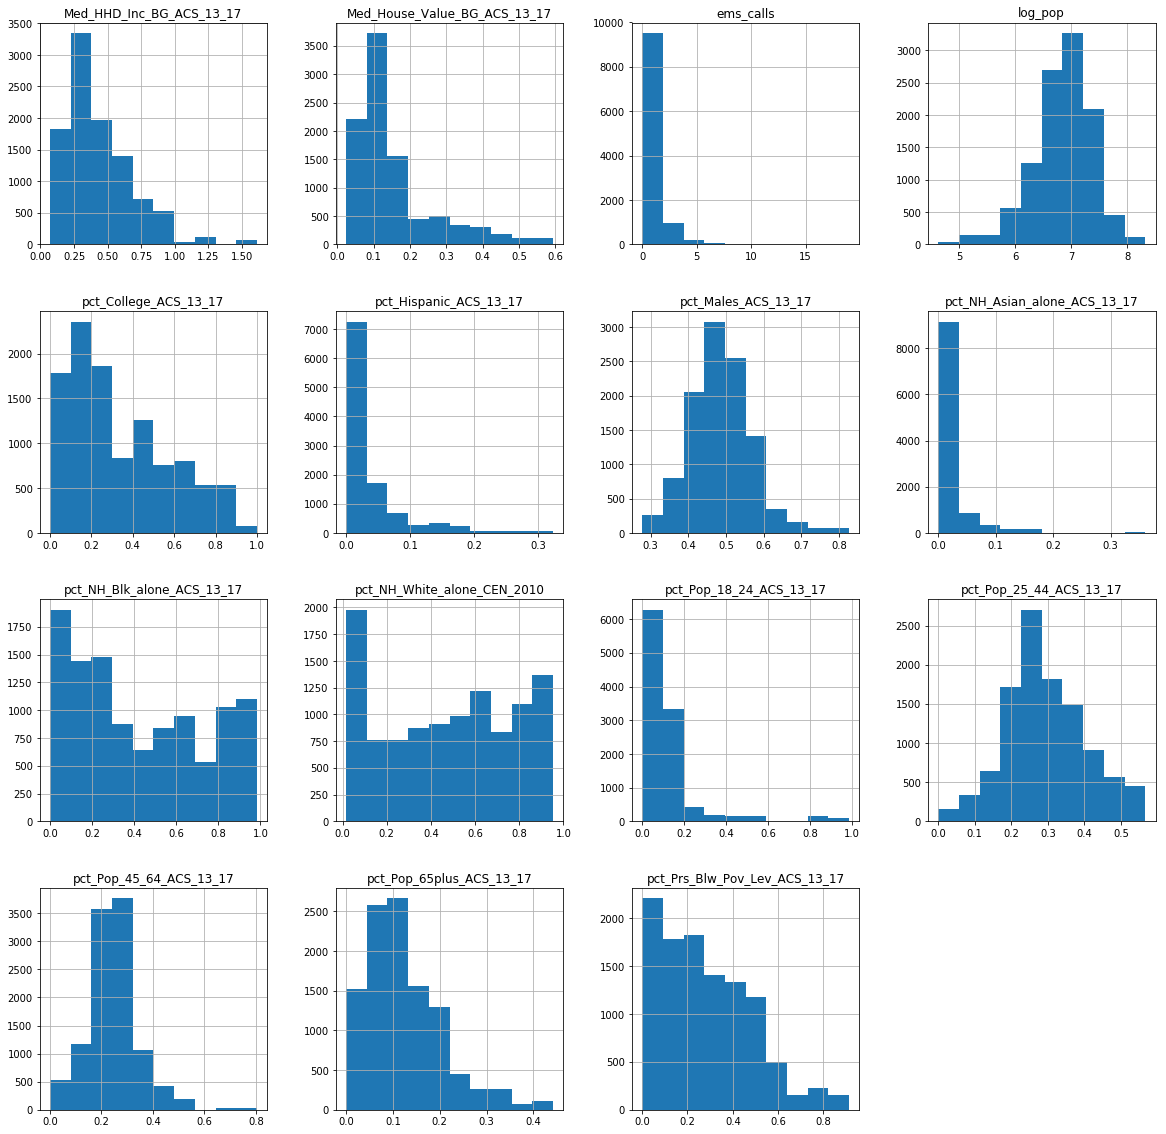

In [69]:
hist = df.drop(columns=['GIDBG', 'year_month'], axis=1)
hist.hist(figsize=(20,20))

In [70]:
desc = hist.describe().T
desc = desc.filter(['mean', 'std'])
desc[1:]

,mean,std
pct_Pop_18_24_ACS_13_17,0.125830,0.153091
pct_Pop_25_44_ACS_13_17,0.294549,0.111066
pct_Pop_45_64_ACS_13_17,0.245376,0.101818
pct_Pop_65plus_ACS_13_17,0.124612,0.082660
pct_Hispanic_ACS_13_17,0.035624,0.055818
pct_NH_White_alone_CEN_2010,0.477446,0.298339
pct_NH_Blk_alone_ACS_13_17,0.421469,0.309971
pct_NH_Asian_alone_ACS_13_17,0.017876,0.037687
Med_HHD_Inc_BG_ACS_13_17,0.435500,0.253567
pct_Prs_Blw_Pov_Lev_ACS_13_17,0.283852,0.202406


In [71]:
#check dispersion --> evidence of over dispersion if var>mean
ems_var = hist.ems_calls.std()**2
print('ems call mean :', hist.ems_calls.mean(), 'ems_call var :', ems_var)

ems call mean : 0.5486471460340994 ems_call var : 1.3387508338735559


In [72]:
sum(df.ems_calls)

5921.0

Text(0.5, 1.0, 'Histogram EMS Calls in Cincinnati 2017.01-2020.02')

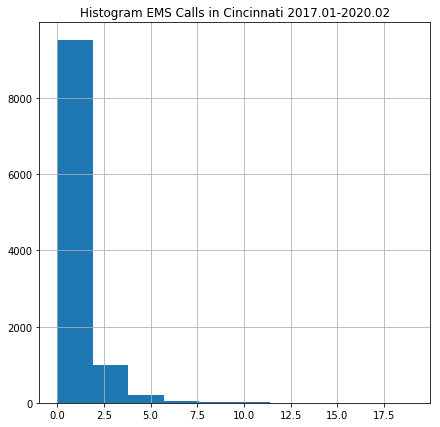

In [73]:
df.ems_calls.hist(figsize=(7,7))
plt.title('Histogram EMS Calls in Cincinnati 2017.01-2020.02')

In [74]:
df.ems_calls.describe().T

count    10792.000000
mean         0.548647
std          1.157044
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
Name: ems_calls, dtype: float64

### High-Lo Analysis 

In [75]:
hi = df[df['ems_calls']>1]
lo = df[df['ems_calls']<=1]


In [76]:
lo.ems_calls.describe()

count    9511.000000
mean        0.216381
std         0.411799
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: ems_calls, dtype: float64

In [77]:
hi.ems_calls.describe()

count    1281.000000
mean        3.015613
std         1.765044
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        19.000000
Name: ems_calls, dtype: float64

In [78]:
hi.head()

,GIDBG,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,pct_NH_White_alone_CEN_2010,pct_NH_Blk_alone_ACS_13_17,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17,geometry,year_month,ems_calls,log_pop
194,3.906101e+11,0.5699,0.4165,0.2515,0.1796,0.0379,0.0505,0.6934,0.1612,0.0107,0.65833,0.1702,0.0479,0.2381,"POLYGON ((-84.56068 39.11014, -84.56056 39.111...",2017.01,2.0,6.937314
206,3.906101e+11,0.4122,0.0848,0.3142,0.2712,0.0514,0.0167,0.5500,0.7204,0.0000,NaN,0.2843,0.0734,0.2552,"POLYGON ((-84.58188 39.11000, -84.58181 39.110...",2017.01,3.0,6.729824
154,3.906101e+11,0.4560,0.0620,0.2953,0.2643,0.1104,0.0407,0.3612,0.5189,0.0000,0.38594,0.2340,0.0686,0.2023,"POLYGON ((-84.53984 39.18366, -84.53674 39.185...",2017.01,2.0,6.940222
211,3.906101e+11,0.4448,0.0759,0.2891,0.1714,0.0806,0.0691,0.4153,0.4883,0.0000,0.23803,0.4773,0.0491,0.0977,"POLYGON ((-84.59271 39.11813, -84.59223 39.118...",2017.01,3.0,7.760041
164,3.906101e+11,0.3978,0.0337,0.3685,0.2360,0.1596,0.0000,0.3679,0.6989,0.0000,0.27022,0.1685,0.0660,0.1529,"POLYGON ((-84.55157 39.16235, -84.55120 39.162...",2017.01,2.0,6.098074


#### Lo-Classification

In [79]:
lo.ems_calls.value_counts()

0.0    7453
1.0    2058
Name: ems_calls, dtype: int64

In [80]:
lo.head()

,GIDBG,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,pct_Pop_45_64_ACS_13_17,pct_Pop_65plus_ACS_13_17,pct_Hispanic_ACS_13_17,pct_NH_White_alone_CEN_2010,pct_NH_Blk_alone_ACS_13_17,pct_NH_Asian_alone_ACS_13_17,Med_HHD_Inc_BG_ACS_13_17,pct_Prs_Blw_Pov_Lev_ACS_13_17,Med_House_Value_BG_ACS_13_17,pct_College_ACS_13_17,geometry,year_month,ems_calls,log_pop
0,3.906100e+11,0.4967,0.1270,0.2294,0.2256,0.1327,0.0038,0.0178,0.9441,0.0000,0.18883,0.5355,NaN,0.0290,"POLYGON ((-84.53186 39.11390, -84.53157 39.113...",2017.01,0.0,6.961296
180,3.906101e+11,0.4074,0.1477,0.1701,0.1747,0.2103,0.0018,0.4850,0.6063,0.0055,0.31875,0.3626,0.1361,0.2941,"POLYGON ((-84.56745 39.19287, -84.56706 39.193...",2017.01,0.0,7.690286
181,3.906101e+11,0.3472,0.1296,0.1250,0.6620,0.0000,0.1620,0.3171,0.5972,0.0000,0.09000,0.5000,0.0800,0.0412,"POLYGON ((-84.58253 39.17047, -84.58252 39.170...",2017.01,1.0,5.375278
182,3.906101e+11,0.4077,0.0678,0.2910,0.1467,0.0267,0.0379,0.0538,0.8222,0.0000,0.17142,0.6301,0.0866,0.1090,"POLYGON ((-84.57038 39.19125, -84.56881 39.191...",2017.01,1.0,7.827640
183,3.906101e+11,0.5208,0.0952,0.1815,0.2976,0.2768,0.1280,0.7764,0.0298,0.0000,0.84875,0.0387,0.2269,0.7165,"POLYGON ((-84.56274 39.17782, -84.55517 39.179...",2017.01,0.0,5.817111


In [81]:
lo.dropna(inplace=True)
X_lo, y_lo = lo, lo.ems_calls
X_lo.drop(['GIDBG', 'geometry', 'year_month', 'ems_calls'], axis=1, inplace=True)

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_lo, y_lo, test_size=0.2, random_state=42)

In [83]:
mod = sm.Logit(y_train, X_train)
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.487780
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              ems_calls   No. Observations:                 6392
Model:                          Logit   Df Residuals:                     6378
Method:                           MLE   Df Model:                           13
Date:                Sun, 08 Mar 2020   Pseudo R-squ.:                 0.04539
Time:                        18:17:24   Log-Likelihood:                -3117.9
converged:                       True   LL-Null:                       -3266.1
                                        LLR p-value:                 1.295e-55
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
pct_Males_ACS_13_17               0.8456      0.482      1.755      0.079      -0.099       1.790
pct_Pop_18_24_ACS_13_17           0.1406      0.428      0.328      0.743      -0.698       0.979
pct_Pop_25_44_ACS_13_17           0.7725      0.513      1.506      0.132      -0.233       1.778
pct_Pop_45_64_ACS_13_17          -0.0861      0.387     -0.222      0.824      -0.846       0.673
pct_Pop_65plus_ACS_13_17          0.3984      0.534      0.747      0.455      -0.648       1.445
pct_Hispanic_ACS_13_17           -0.1199      0.574     -0.209      0.835      -1.244       1.005
pct_NH_White_alone_CEN_2010      -0.8879      0.303     -2.926      0.003      -1.483      -0.293
pct_NH_Blk_alone_ACS_13_17       -1.8178      0.327     -5.554      0.000      -2.459      -1.176
pct_NH_Asian_alone_ACS_13_17      1.7971      1.188      1.513      0.130      -0.531       4.125
Med_HHD_Inc_BG_ACS_13_17         -0.6735      0.291     -2.313      0.021      -1.244      -0.103
pct_Prs_Blw_Pov_Lev_ACS_13_17     1.0376      0.272      3.820      0.000       0.505       1.570
Med_House_Value_BG_ACS_13_17      0.9462      0.541      1.748      0.080      -0.115       2.007
pct_College_ACS_13_17            -2.5317      0.353     -7.173      0.000      -3.223      -1.840
log_pop                          -0.0189      0.058     -0.323      0.747      -0.133       0.096
=================================================================================================
"""

In [84]:
'''
DG Notes 030820: 

Statistically significant regressors are percent white(-), percent black(-), 
median household income(-), percent below poverty(+), median household value(+), 
percent college educated(-)

Weird that the calls *increase* by such a high amount with indicators in home value?
Also odd that we don't see calls increase with population?

pseudo r2 is still incredibly low. Is this just because we're looking at noise and imbalanced classes?
Model performs poorly
'''

"\nDG Notes 030820: \n\nStatistically significant regressors are percent white(-), percent black(-), \nmedian household income(-), percent below poverty(+), median household value(+), \npercent college educated(-)\n\nWeird that the calls *increase* by such a high amount with indicators in home value?\nAlso odd that we don't see calls increase with population?\n\npseudo r2 is still incredibly low. Is this just because we're looking at noise and imbalanced classes?\nModel performs poorly\n"

In [85]:
#### Try other classifiers? Pseudo r2 sucks?

#### Hi-Analysis

In [86]:
hi.dropna(inplace=True)
X_hi, y_hi = hi, hi.ems_calls
X_hi.drop(['GIDBG', 'geometry', 'year_month', 'ems_calls'], axis=1, inplace=True)

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [87]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_hi, y_hi, test_size=0.2, random_state=42)

In [90]:
mod = sm.OLS(y_train, X_train)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ems_calls   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     217.9
Date:                Sun, 08 Mar 2020   Prob (F-statistic):          6.30e-256
Time:                        19:03:23   Log-Likelihood:                -1419.3
No. Observations:                 781   AIC:                             2867.
Df Residuals:                     767   BIC:                             2932.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
pct_Males_ACS_13_17               0.5723      0.874      0.655      0.513      -1.143       2.287
pct_Pop_18_24_ACS_13_17           0.8357      0.751      1.113      0.266      -0.638       2.309
pct_Pop_25_44_ACS_13_17           3.2470      1.007      3.224      0.001       1.270       5.224
pct_Pop_45_64_ACS_13_17           1.0903      0.834      1.308      0.191      -0.546       2.727
pct_Pop_65plus_ACS_13_17          0.4872      1.081      0.451      0.652      -1.635       2.610
pct_Hispanic_ACS_13_17            1.4673      1.041      1.410      0.159      -0.576       3.510
pct_NH_White_alone_CEN_2010      -1.2835      0.557     -2.304      0.022      -2.377      -0.190
pct_NH_Blk_alone_ACS_13_17       -1.2100      0.600     -2.017      0.044      -2.388      -0.032
pct_NH_Asian_alone_ACS_13_17      0.5675      1.835      0.309      0.757      -3.034       4.169
Med_HHD_Inc_BG_ACS_13_17          1.5868      0.538      2.951      0.003       0.531       2.642
pct_Prs_Blw_Pov_Lev_ACS_13_17     0.7578      0.502      1.510      0.131      -0.227       1.743
Med_House_Value_BG_ACS_13_17      3.7535      1.091      3.440      0.001       1.611       5.896
pct_College_ACS_13_17            -2.1441      0.745     -2.880      0.004      -3.606      -0.683
log_pop                           0.2047      0.104      1.976      0.048       0.001       0.408
==============================================================================
Omnibus:                      552.547   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10483.359
Skew:                           2.963   Prob(JB):                         0.00
Kurtosis:                      19.942   Cond. No.                         244.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
'''
DG Notes 030820: 

Statistically significant regressors are percent of individuals 25-44 (+), percent white(-), percent black(-), 
median household income(+), median household value(+), percent college educated(-), log of the population(+)

Weird that the calls *increase* by such a high amount with indicators of wealth in hhi and home value?
'''

'\nDG Notes 030820: \n\nStatistically significant regressors are percent of individuals 25-44 (+), percent white(-), percent black(-), \nmedian household income(+), median household value(+), percent college educated(-), log of the population(+)\n\nWeird that the calls *increase* by such a high amount with indicators of wealth in hhi and home value?\n'

In [91]:
#try poisson
res = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              ems_calls   No. Observations:                  781
Model:                            GLM   Df Residuals:                      767
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1333.6
Date:                Sun, 08 Mar 2020   Deviance:                       415.75
Time:                        19:04:28   Pearson chi2:                     503.
No. Iterations:                     5   Covariance Type:             nonrobust
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
pct_Males_ACS_13_17               0.2250      0.337      0.668      0.504      -0.435       0

In [ ]:
'''
DG Notes 030820: 

Statistically significant regressors are percent of individuals 25-44 (+), 
median household income(+), median household value(+), percent college educated(-), log of the population(+)

Weird that the calls *increase* by such a high amount with indicators of wealth in hhi and home value?
'''